# Table of Contents
 <p>

In [94]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import epistasis as epi
import numba 
from matplotlib import rc

import os
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})


%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [20]:
strains =['ps4187', 'ps4087', 'ps4176']

strain_dict = {}
for i, g in enumerate(strains):
    strain_dict[g] = i

In [21]:
q = 0.1

In [22]:
genmap = pd.read_csv('../sleuth/rna_seq_info.txt', sep=' ', comment='#')
tidy  = pd.read_csv('../input/quantifications.csv')

tidy = tidy[tidy.strain.isin(strains)]

In [35]:
overlap4087 = epi.find_overlap(['ps4087', 'ps4176'], tidy)
overlap4187 = epi.find_overlap(['ps4187', 'ps4176'], tidy)

sy622_associated = tidy[(tidy.target_id.isin(overlap4087)) & (~tidy.target_id.isin(overlap4187))].target_id.unique()
bx93_associated = tidy[(tidy.target_id.isin(overlap4187))].target_id.unique()
sy622_specific = tidy[(~tidy.target_id.isin(overlap4087)) & (~tidy.target_id.isin(overlap4187)) & (tidy.qval < q) & (tidy.strain == 'ps4087')].target_id.unique()
transhet_specific = tidy[(~tidy.target_id.isin(overlap4087)) & (~tidy.target_id.isin(overlap4187)) & (tidy.qval < q) & (tidy.strain == 'ps4176')].target_id.unique()


classes = {'sy622 associated': sy622_associated,
           'bx93 associated': bx93_associated,
           'sy622 specific': sy622_specific,
           'transhet specific': transhet_specific}

In [36]:
inv_classes = {}

for key, value in classes.items():
    n = len(tidy[tidy.target_id.isin(value)].ens_gene.unique())
    print(key, n)
    
    for v in value:
        inv_classes[v] = key

sy622 specific 1623
bx93 associated 310
transhet specific 1676
sy622 associated 989


In [37]:
tidy['phenotypic class'] = tidy.target_id.map(inv_classes)

bx93 associated mean: 1.3, median: 0.96
bx93 associated 95 percentile: 4.2
sy622 associated mean: 0.99, median: 0.55
sy622 associated 95 percentile: 3.3
sy622 specific mean: 0.9, median: 0.56
sy622 specific 95 percentile: 3


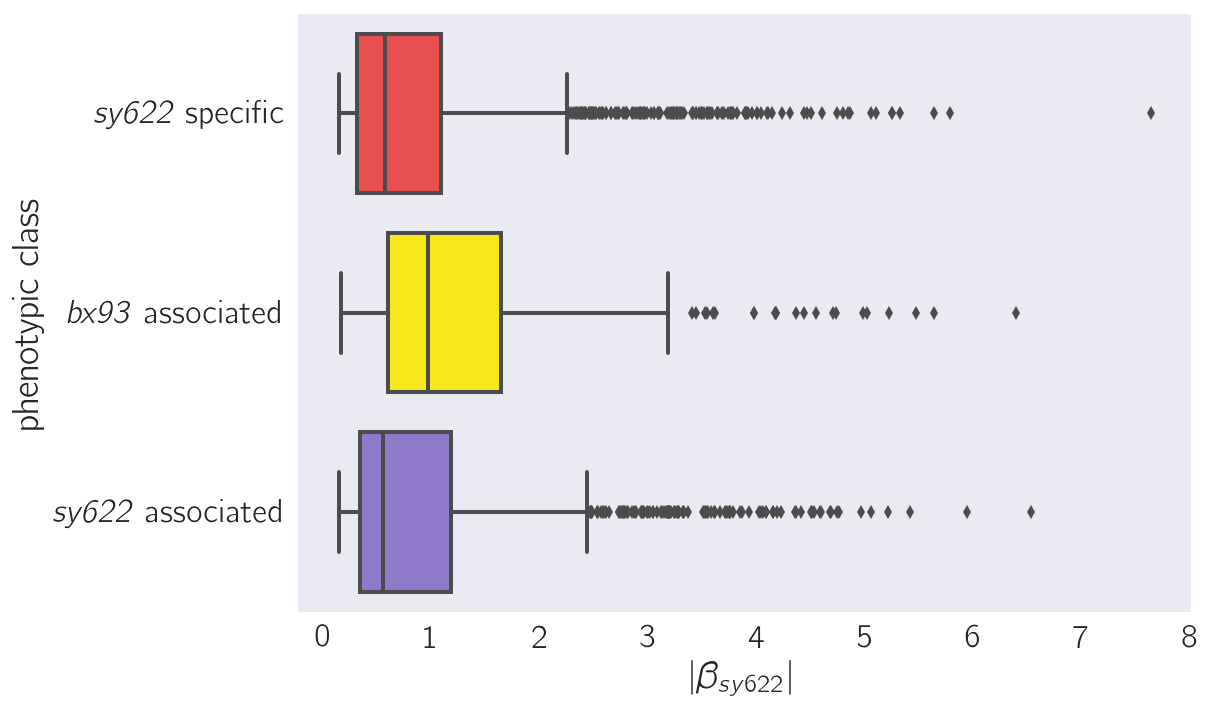

In [155]:
temp = tidy[(tidy.qval < q) & (tidy.strain == 'ps4087')].dropna().copy()
temp.b = temp.b.abs()
sns.boxplot(y='phenotypic class', x='b', data=temp)
plt.xlabel(r'$|\beta_{sy622}|$')
plt.gca().set_yticklabels([r'\emph{sy622} specific', r'\emph{bx93} associated', r'\emph{sy622} associated'])

plt.gca().artists[0].set_facecolor('#E85050')
plt.gca().artists[1].set_facecolor('#F7E71D')
plt.gca().artists[2].set_facecolor('#8F79CA')
plt.savefig('../output/beta_values_phenotypic_classes_sy622.svg', bbox_inches='tight')

grouped = temp.groupby('phenotypic class')
for name, group in grouped:
    print("{0} mean: {1:.2g}, median: {2:.2g}".format(name, group.b.mean(), np.median(group.b)))
    print("{0} 95 percentile: {1:.2g}".format(name, group.b.quantile(.95)))

In [117]:
@numba.jit(nopython=True)
def bootstrap_difference_of_means(x, y, n=10**4):
    """Given two datasets, return a pvalue for null H (their means are the same)."""
    nx = len(x)
    ny = len(y)

    mixed = np.zeros(nx + ny)
    mixed[0:nx] = x
    mixed[nx:] = y
    
    delta = np.zeros(n)

    for i in np.arange(n):
        nullx = np.random.choice(mixed, nx, replace=True)
        nully = np.random.choice(mixed, ny, replace=True)
        diff = nully.mean() - nullx.mean()
        delta[i] = diff

    return delta

pvalue is 0.00


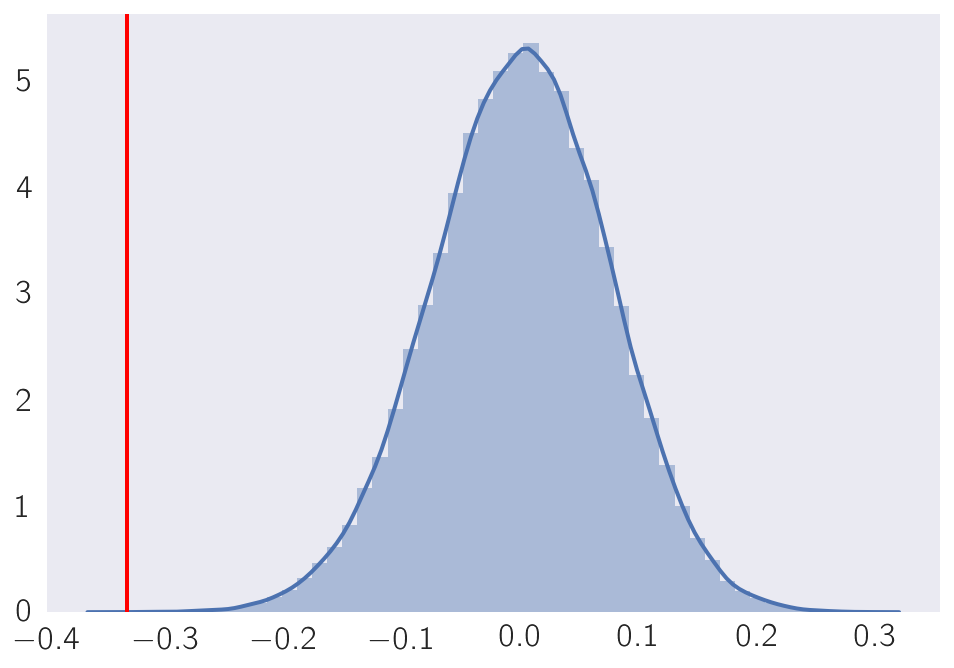

In [114]:
x = temp[temp['phenotypic class'] == 'bx93 associated'].b.values
y = temp[temp['phenotypic class'] == 'sy622 associated'].b.values

delta = bootstrap_difference_of_means(x, y, n=10**5)

sns.distplot(delta)
plt.axvline(y.mean() - x.mean(), color='red')

pval = len(delta[delta < y.mean() - x.mean()])/len(delta)
print('pvalue is {0:.2f}'.format(pval))

pvalue is 0.00


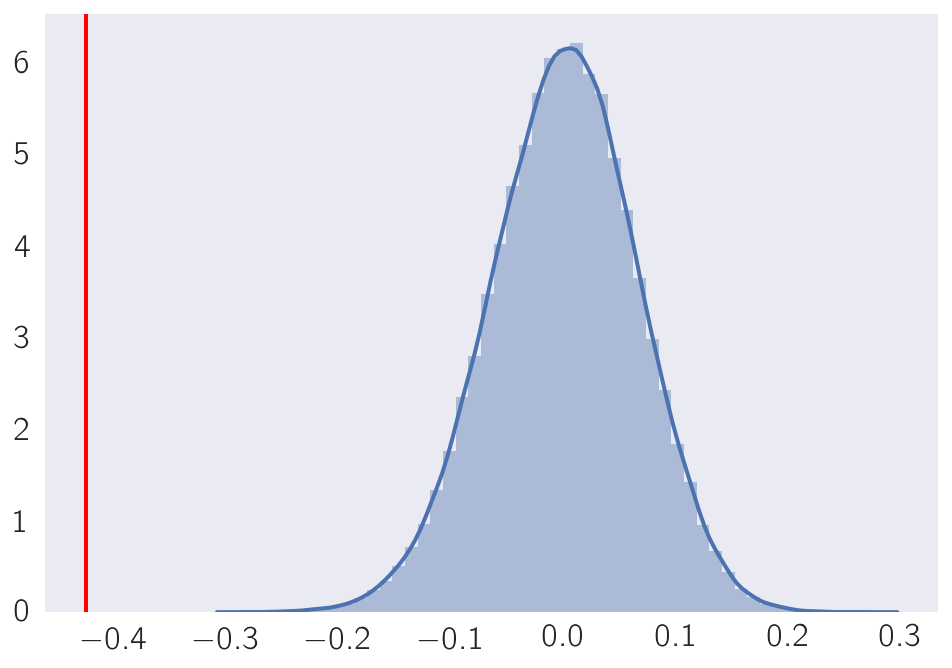

In [115]:
y = temp[temp['phenotypic class'] == 'sy622 specific'].b.values

delta = bootstrap_difference_of_means(x, y, n=10**5)

sns.distplot(delta)
plt.axvline(y.mean() - x.mean(), color='red')

pval = len(delta[delta < y.mean() - x.mean()])/len(delta)
print('pvalue is {0:.2f}'.format(pval))

pvalue is 0.01


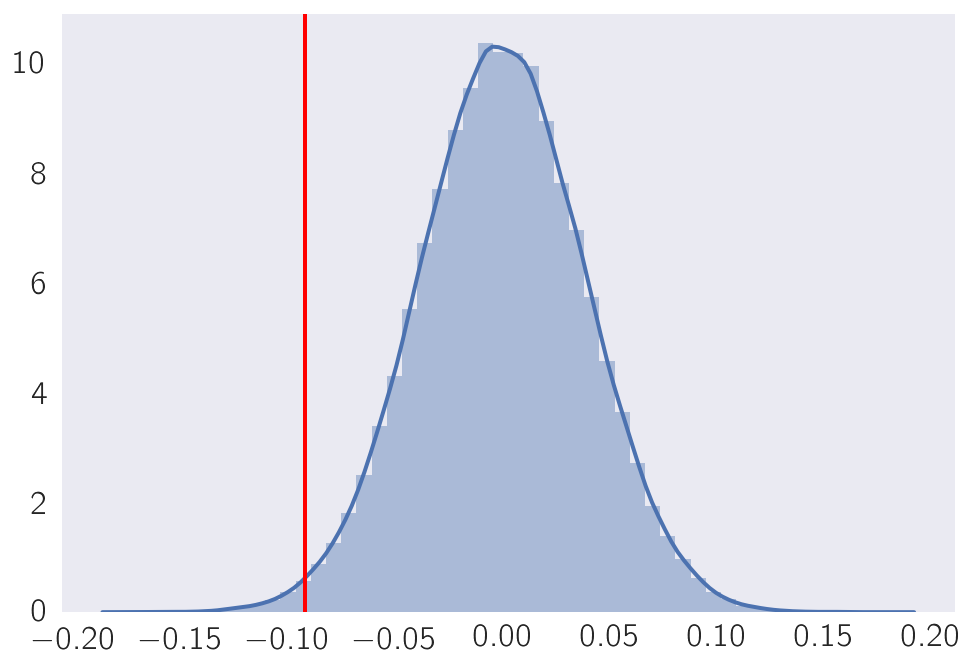

In [116]:
x = temp[temp['phenotypic class'] == 'sy622 associated'].b.values
y = temp[temp['phenotypic class'] == 'sy622 specific'].b.values

delta = bootstrap_difference_of_means(x, y, n=10**5)

sns.distplot(delta)
plt.axvline(y.mean() - x.mean(), color='red')

pval = len(delta[delta < y.mean() - x.mean()])/len(delta)
print('pvalue is {0:.2f}'.format(pval))

In [93]:
tidy.drop(['Unnamed: 0', 'absb', 'order'], axis=1).to_csv('../output/dpy_22_results.csv')

In [137]:
import tissue_enrichment_analysis as ea

In [139]:
tissue = ea.fetch_dictionary('tissue')
pheno = ea.fetch_dictionary('phenotype')
go = ea.fetch_dictionary('go')

In [148]:
tissues = {}
phenos = {}
gos = {}
for key, value in classes.items():
    ids = tidy[tidy.target_id.isin(value)].ens_gene.unique()
    tissues[key] = ea.enrichment_analysis(ids, tissue, show=False)
    phenos[key] = ea.enrichment_analysis(ids, pheno, show=False)
    gos[key] = ea.enrichment_analysis(ids, go, show=False)

In [149]:
for key, t in tissues.items():
    if len(t) != 0:
        print(key)
        print(t)

sy622 specific
                                           Tissue    Expected  Observed  \
132                    gon herm sujn WBbt:0008210   76.473760       147   
164                          Nucleus WBbt:0006803   77.318774       148   
158  spermathecal-uterine valve cell WBbt:0008217   78.586295       149   
48                         intestine WBbt:0005772  590.453482       764   
148                    somatic gonad WBbt:0005785  130.554652       217   
75     spermathecal-uterine junction WBbt:0006756   82.916992       152   
150                    hermaphrodite WBbt:0007849  318.675877       438   
95             anal depressor muscle WBbt:0004292   48.905181        90   
204                  muscular system WBbt:0005737  530.880000       639   
56                 intestinal muscle WBbt:0005796   21.019721        42   
78                         sex organ WBbt:0008422  171.009694       219   
211               lateral nerve cord WBbt:0006769   43.729471        68   
22        

In [150]:
for key, t in phenos.items():
    if len(t) != 0:
        print(key)
        print(t)

sy622 specific
                                                Tissue    Expected  Observed  \
123          avoids bacterial lawn WBPhenotype:0000402   49.865338        98   
4                gonad vesiculated WBPhenotype:0001979   22.798792        49   
47   pleiotropic defects severe early emb WBPhenoty...   13.589428        32   
75                   rachis narrow WBPhenotype:0001941   31.334300        57   
155                  rachis absent WBPhenotype:0001942    9.658601        24   
80             shortened life span WBPhenotype:0001171   49.640719        76   
175    meiosis defective early emb WBPhenotype:0001041    9.321674        21   
210                   molt variant WBPhenotype:0002041   31.671228        52   
171  transgene expression increased WBPhenotype:000...  119.384806       156   
173           oocytes lack nucleus WBPhenotype:0001956   13.140190        26   
59   diakinesis progression during oogenesis varian...   12.466334        25   
63   diplotene region org

In [152]:
for key, t in gos.items():
    if len(t) != 0:
        print(key)
        print(t[t['Enrichment Fold Change'] > 3.5])

sy622 specific
                                                Tissue   Expected  Observed  \
261                      embryo development GO:0009790  98.594453       368   
235              post-embryonic development GO:0009791  70.377488       299   
73                                    aging GO:0007568  28.306923       148   
167                         collagen trimer GO:0005581   5.727354        44   
190                           molting cycle GO:0042303  14.213434        64   
86            multicellular organism growth GO:0035264  12.414265        56   
110           positive regulation of growth GO:0045927  11.874514        52   
275                   immune system process GO:0002376  10.285249        46   
159             response to biotic stimulus GO:0009607   5.277562        31   
133                       contractile fiber GO:0043292   6.327077        33   
1                   muscle cell development GO:0055001   5.097645        29   
156  cellular component assembly invo